# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import json
import requests
import datetime as dt
import time
import yfinance as yf  
import statsmodels.api as sm
import sklearn.linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# Import and process S&P500 data

In [2]:
# import SPY data

#define yesterday 

ticker = '^GSPC'

yesterday = dt.date.today()

last_53_years = dt.date.today() - dt.timedelta(days=19366)

#pull data up to yesterday

df = yf.download(ticker,last_53_years,yesterday)

df.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-05,0.0,94.250000,92.529999,93.459999,93.459999,11490000
1970-01-06,0.0,93.809998,92.129997,92.820000,92.820000,11460000


In [3]:
# reset index

df = df.reset_index()

# drop unnecesary columns

df = df.drop(['Open', 'High','Low','Adj Close', 'Volume'], axis = 1)

# rename columns

df = df.rename(columns={'Date':'date', 'Close': 'close'})

# convert date to time 

df['date'] = pd.to_datetime(df['date'])

In [4]:
# calculate the 2-year forward returns of the S&P

df['2years_forward'] = df['date'] + np.timedelta64(2,'Y')

df['2years_forward']= df['2years_forward'].dt.strftime('%Y-%m-%d')

df['2years_forward'] = pd.to_datetime(df['2years_forward'])
 
df.head(2)

,date,close,2years_forward
0,1970-01-05,93.459999,1972-01-05
1,1970-01-06,92.820000,1972-01-06


In [5]:
# create a separate df to map the price 2-years ahead 

df_spy1 = df[['date','close']]

df_spy1 = df_spy1.rename(columns={'date':'2years_forward'})

df_spy2 = df['2years_forward']

# merge using 2-year forward dates 

df_spy2 = pd.merge(df_spy2,
                   df_spy1,
                   on = '2years_forward',
                   how = 'left')

df_spy2.head(2)

,2years_forward,close
0,1972-01-05,103.059998
1,1972-01-06,103.510002


In [6]:
# merge back using the new df

df = pd.merge(df,
              df_spy2,
              on = '2years_forward',
              how = 'left')

#rename columns               

df = df.rename(columns={'close_y':'2year_forward_return', 'close_x':'close'})              

df.head(2)

,date,close,2years_forward,2year_forward_return
0,1970-01-05,93.459999,1972-01-05,103.059998
1,1970-01-06,92.820000,1972-01-06,103.510002


# Import and process UST 10y yield

In [7]:
#define the ticker and import the data

ticker = '^TNX'

last_55_years = dt.date.today() - dt.timedelta(days=20075)

df_t = yf.download(ticker, last_55_years, yesterday)

df_t.head(2)



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1968-01-29,5.53,5.53,5.53,5.53,5.53,0
1968-01-30,5.53,5.53,5.53,5.53,5.53,0


In [8]:
# reset index

df_t = df_t.reset_index()

# drop unnecesary columns

df_t = df_t.drop(['Open', 'High','Low','Adj Close', 'Volume'], axis = 1)

# rename columns

df_t = df_t.rename(columns={'Date':'date', 'Close': 'close'})

# convert date to time 

df_t['date'] = pd.to_datetime(df_t['date'])

In [9]:
# repeat the same process for yields but looking 2 years back

df_t['2years_backward'] = df_t['date'] - np.timedelta64(2,'Y')

df_t['2years_backward']= df_t['2years_backward'].dt.strftime('%Y-%m-%d')

df_t['2years_backward'] = pd.to_datetime(df_t['2years_backward'])
 

In [10]:
# create a separate df to map the price 2-years backward

df_t1 = df_t[['date','close']]

df_t1 = df_t1.rename(columns={'date':'2years_backward'})

df_t2 = df_t['2years_backward']

# merge using 2-year forward dates 

df_t2 = pd.merge(df_t2,
                   df_t1,
                   on = '2years_backward',
                   how = 'left')
# merge back using the new df

df_t = pd.merge(df_t,
              df_t2,
              on = '2years_backward',
              how = 'left')

#rename columns 
df_t = df_t.rename(columns={'close_y':'2year_back_10y_yield', 'close_x':'10y_yield'})              

df_t.tail(2)

,date,10y_yield,2years_backward,2year_back_10y_yield
13753,2023-01-11,3.554,2021-01-10,NaN
13754,2023-01-12,3.449,2021-01-11,1.132


In [11]:
#merge back the 2-year backward yield to the main df

df_t = df_t[['date', '10y_yield', '2year_back_10y_yield']]

df = pd.merge(df,
              df_t,
              on = 'date',
              how = 'left')

df.head(2)

,date,close,2years_forward,2year_forward_return,10y_yield,2year_back_10y_yield
0,1970-01-05,93.459999,1972-01-05,103.059998,7.88,NaN
1,1970-01-06,92.820000,1972-01-06,103.510002,7.96,NaN


In [12]:
# calculate the % difference in the 10y bond yield and the S&P500

df['spy_diff'] = (df['2year_forward_return'] - df['close'])/df['close']*100

df['10y_yield_diff'] = df['2year_back_10y_yield'] - df['10y_yield']


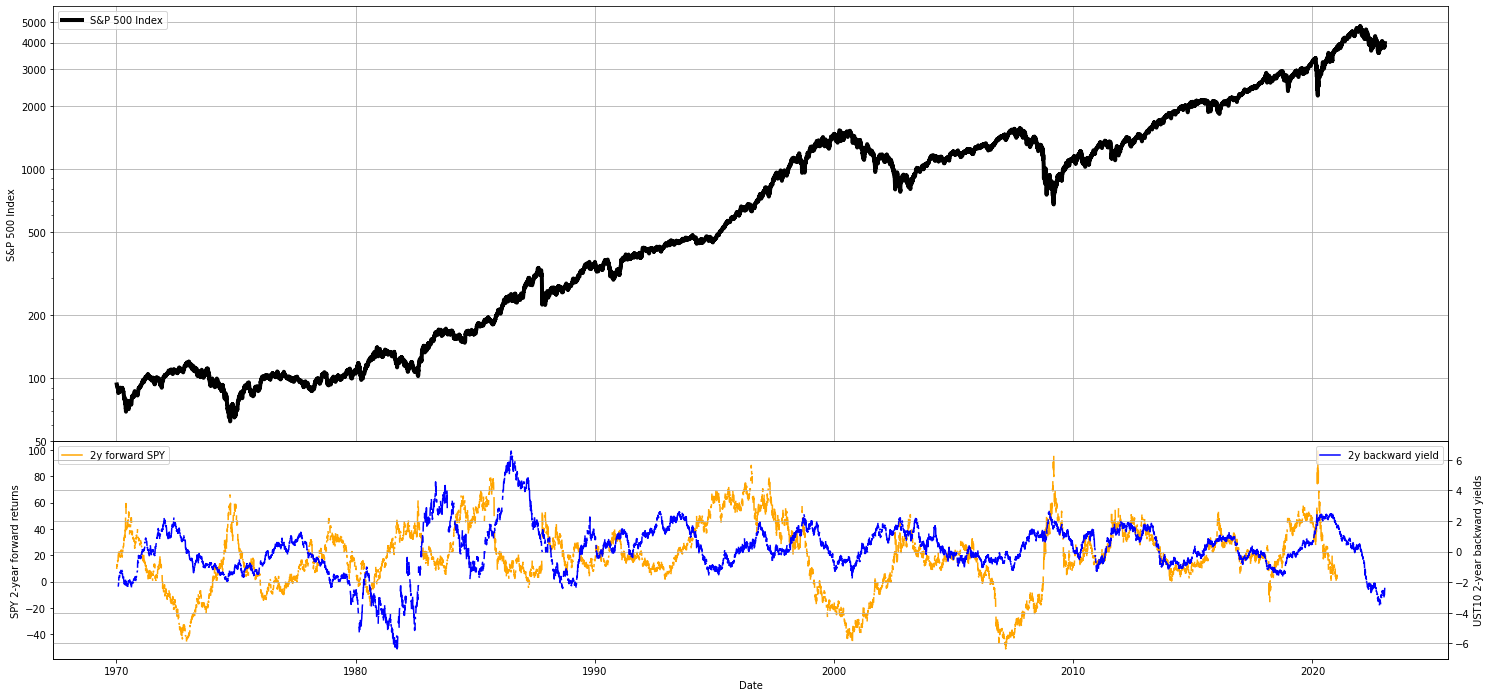

In [13]:
# plot just the 2-year forward and backward 

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2,1]}, figsize=(25,12))

#plot spy data

ticks = [50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]

ax0.plot(df['date'],df['close'], color = 'black', linewidth = 4)
ax0.set_ylabel('S&P 500 Index')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index'])

ax1.plot(df['date'],df['spy_diff'], color = 'orange')
# axes object for secondary y-Axis
ax15 = ax1.twinx()
ax15.plot(df['date'],df['10y_yield_diff'], color = 'blue')
# giving labels to the axises
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY 2-year forward returns')
# secondary y-axis label
ax15.set_ylabel('UST10 2-year backward yields')

ax15.grid(True)

ax1.legend(labels=['2y forward SPY', '2y backward yield'], loc='upper left')
ax15.legend(labels=['2y backward yield'])

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)

plt.show()



In [14]:
# Filter data between two dates
df_2010 = df.loc[(df['date'] >= '2010-01-01')
                     & (df['date'] <= str(yesterday))]

#find correlation between the 2-year backward looking yields and SPY 2y forward looking returns
corr = df_2010["spy_diff"].corr(df_2010["10y_yield_diff"])
print("Correlation between 2-year forward SPY returns and 2-year UST10 yield difference is", round(corr, 2))


Correlation between 2-year forward SPY returns and 2-year UST10 yield difference is 0.5


# Import Fed Funds rate data

In [15]:
#start with fed funds rate

#data from https://fred.stlouisfed.org/series/FEDFUNDS

df_fedfr = pd.read_csv("/Users/oriold/Desktop/FEDFUNDS.csv")

df_fedfr.head(2)

,DATE,FEDFUNDS
0,1970-01-01,8.98
1,1970-02-01,8.98


In [16]:
#rename column 'DATE' to month

df_fedfr = df_fedfr.rename(columns={'DATE':'date', 'FEDFUNDS':'fed_funds_rate'})

#convert date to datetime

df_fedfr['date'] = pd.to_datetime(df_fedfr['date'])

#join monthly fed funds rate with original df

df = pd.merge(df, 
              df_fedfr, 
              on ='date', 
              how ='left')

# fill empty values with the previous one https://stackoverflow.com/questions/27905295/how-to-replace-nans-by-preceding-or-next-values-in-pandas-dataframe

df['fed_funds_rate'].fillna(method='ffill', inplace=True)              

In [17]:
# calculate the difference between 10y yield and fed funds rate 

df['fedfunds_10y_yield_diff'] = df['10y_yield'] - df['fed_funds_rate']

In [18]:
#add the 2-year backward date to the main df

df['2years_backward'] = df['date'] - np.timedelta64(2,'Y')

df['2years_backward']= df['2years_backward'].dt.strftime('%Y-%m-%d')

df['2years_backward'] = pd.to_datetime(df['2years_backward'])
 

In [19]:
# calculate fed fund rate 2-year backward difference

df_fedfunds2 = df['2years_backward']

df_fedfunds1 = df[['date','fed_funds_rate']]

df_fedfunds1 = df_fedfunds1.rename(columns={'date':'2years_backward'})

# merge using 2-year forward dates 

df_fedfunds2 = pd.merge(df_fedfunds2,
                   df_fedfunds1,
                   on = '2years_backward',
                   how = 'left')

# merge back using the new df

df = pd.merge(df,
              df_fedfunds2,
              on = '2years_backward',
              how = 'left')

#rename columns 

df = df.rename(columns={'fed_funds_rate_x':'fed_funds_rate', 'fed_funds_rate_y':'2y_back_fed_funds_rate'})              

df.head(2)

,date,close,2years_forward,2year_forward_return,10y_yield,2year_back_10y_yield,spy_diff,10y_yield_diff,fed_funds_rate,fedfunds_10y_yield_diff,2years_backward,2y_back_fed_funds_rate
0,1970-01-05,93.459999,1972-01-05,103.059998,7.88,NaN,10.271772,NaN,NaN,NaN,1968-01-05,NaN
1,1970-01-06,92.820000,1972-01-06,103.510002,7.96,NaN,11.516917,NaN,NaN,NaN,1968-01-06,NaN


In [20]:
#df = df.rename(columns={'fed_funds_rate_x':'fed_funds_rate', 'fed_funds_rate_y':'2y_back_fed_funds_rate'})

In [21]:
# calculate the difference in fed funds rate looking back 2-years 

df['fedfunds_2y_back_diff'] = df['2y_back_fed_funds_rate'] - df['fed_funds_rate']

# Import M2 money supply

In [22]:
# continue with M2 money supply

# data source https://fred.stlouisfed.org/series/M2SL

df_fedm2 = pd.read_csv("/Users/oriold/Desktop/M2SL.csv")

df_fedm2.head(2)

,DATE,M2SL
0,1970-01-01,589.6
1,1970-02-01,586.3


In [23]:
#rename column 'DATE' to month

df_fedm2 = df_fedm2.rename(columns={'DATE':'date', 'M2SL':'fed_M2_USDB'})

#convert date to datetime

df_fedm2['date'] = pd.to_datetime(df_fedm2['date'])

#join monthly fed assets with original df

df = pd.merge(df, 
              df_fedm2, 
              on ='date', 
              how ='left')

# fill empty values with the previous one https://stackoverflow.com/questions/27905295/how-to-replace-nans-by-preceding-or-next-values-in-pandas-dataframe

df['fed_M2_USDB'].fillna(method='ffill', inplace=True)

In [24]:
#calculate the 2y backward difference in M2 money supply

df_M2 = df['2years_backward']

df_M1 = df[['date','fed_M2_USDB']]

df_M1 = df_M1.rename(columns={'date':'2years_backward'})

# merge using 2-year forward dates 

df_M2 = pd.merge(df_M2,
                   df_M1,
                   on = '2years_backward',
                   how = 'left')

# merge back using the new df

df = pd.merge(df,
              df_M2,
              on = '2years_backward',
              how = 'left')

#rename columns

df = df.rename(columns={'fed_M2_USDB_x':'fed_M2_USDB', 'fed_M2_USDB_y':'2y_back_fed_M2_USDB'})

In [25]:
# calculate the 2-year difference in M2 supply 

df['M2_2y_back_diff'] = (df['2y_back_fed_M2_USDB'] - df['fed_M2_USDB'])/df['fed_M2_USDB']

# Import fed assets data

In [26]:
# continue with M2 money supply

# data source https://fred.stlouisfed.org/series/M2SL

df_assets = pd.read_csv("/Users/oriold/Desktop/WALCL.csv")

df_assets.head(2)

,DATE,WALCL
0,2002-12-18,719542.0
1,2002-12-25,732059.0


In [27]:
#rename column 'DATE' to month

df_assets = df_assets.rename(columns={'DATE':'date', 'WALCL':'fed_assets'})

#convert date to datetime

df_assets['date'] = pd.to_datetime(df_assets['date'])

#join monthly fed assets with original df

df = pd.merge(df, 
              df_assets, 
              on ='date', 
              how ='left')

# fill empty values with the previous one 

df['fed_assets'].fillna(method='ffill', inplace=True)              

In [28]:
#calculate the 2y backward difference in Fed assets

df_assets2 = df['2years_backward']

df_assets1 = df[['date','fed_assets']]

df_assets1 = df_assets1.rename(columns={'date':'2years_backward'})

# merge using 2-year forward dates 

df_assets2 = pd.merge(df_assets2,
                   df_assets1,
                   on = '2years_backward',
                   how = 'left')

# merge back using the new df

df = pd.merge(df,
              df_assets2,
              on = '2years_backward',
              how = 'left')    

# rename columns                              

df = df.rename(columns={'fed_assets_x':'fed_assets', 'fed_assets_y':'2y_back_fed_assets'})

In [29]:
# calculate the 2-year rate of change in Fed Assets 

df['fed_assets_2y_back_diff'] = (df['2y_back_fed_assets'] - df['fed_assets'])/df['fed_assets']

# Import data for the Shiller P/E ratio

In [30]:
# Add earnings per share
# Earnings data from https://www.gurufocus.com/economic_indicators/56/shiller-pe-ratio-for-the-sp-500

df_shiller_pe = pd.read_excel("/Users/oriold/Desktop/Shiller PE Ratio for the S&P 500 2023-01-10 14_58_30.xlsx")

df_shiller_pe.head(2)

,Date,Value
0,2022-12-01,27.95
1,2022-11-01,28.46


In [31]:
#rename column 'DATE' to month

df_shiller_pe = df_shiller_pe.rename(columns={'Date':'date', 'Value':'shiller_pe'})

#convert date to datetime

df_shiller_pe['date'] = pd.to_datetime(df_shiller_pe['date'])

#join monthly earings with original df

df = pd.merge(df, 
              df_shiller_pe, 
              on ='date', 
              how ='left')

#fill empty values 

df['shiller_pe'].fillna(method='ffill', inplace=True)              

In [32]:
#calculate the 2y backward difference in Shiller PE ratio

df_sh2 = df['2years_backward']

df_sh1 = df[['date','shiller_pe']]

df_sh1 = df_sh1.rename(columns={'date':'2years_backward'})

# merge using 2-year forward dates 

df_sh2 = pd.merge(df_sh2,
                   df_sh1,
                   on = '2years_backward',
                   how = 'left')

# merge back using the new df

df = pd.merge(df,
              df_sh2,
              on = '2years_backward',
              how = 'left')

df = df.rename(columns={'shiller_pe_x':'shiller_pe', 'shiller_pe_y':'2y_back_shiller_pe'})

In [33]:
# calculate the 2-year rate of change of the shiller PE ratio 

df['shiller_pe_2y_back_diff'] = (df['2y_back_shiller_pe'] - df['shiller_pe'])/df['shiller_pe']

#fill empty values 

df['shiller_pe_2y_back_diff'].fillna(method='ffill', inplace=True)

# Import 12month trailing P/E ratio

In [34]:
# Add earnings per share
# Earnings data from https://www.multpl.com/s-p-500-pe-ratio/table/by-month

df_pe = pd.read_excel("/Users/oriold/Desktop/sp500_pe_ratio.xlsx")

df_pe.head(2)

,date,ttm_pe_ratio
0,2023-01-12,20.63
1,2023-01-01,19.89


In [35]:
#convert date to datetime

df_pe['date'] = pd.to_datetime(df_pe['date'])

#join monthly earings with original df

df = pd.merge(df, 
              df_pe, 
              on ='date', 
              how ='left')

#fill empty values 

df['ttm_pe_ratio'].fillna(method='ffill', inplace=True)              

In [36]:
#calculate the 2y backward difference in Shiller PE ratio

df_pe2 = df['2years_backward']

df_pe1 = df[['date','ttm_pe_ratio']]

df_pe1 = df_pe1.rename(columns={'date':'2years_backward'})

# merge using 2-year forward dates 

df_pe2 = pd.merge(df_pe2,
                   df_pe1,
                   on = '2years_backward',
                   how = 'left')

# merge back using the new df

df = pd.merge(df,
              df_pe2,
              on = '2years_backward',
              how = 'left')

df = df.rename(columns={'ttm_pe_ratio_x':'ttm_pe_ratio', 'ttm_pe_ratio_y':'2y_back_ttm_pe_ratio'})

In [37]:
# calculate the 2-year rate of change of the PE ratio 

df['ttm_pe_ratio_2y_back_diff'] = (df['2y_back_ttm_pe_ratio'] - df['ttm_pe_ratio'])/df['ttm_pe_ratio']

#fill empty values 

df['ttm_pe_ratio_2y_back_diff'].fillna(method='ffill', inplace=True)

# Add S&P500 dividend yields 

In [38]:
# Add earnings per share
# Earnings data from https://www.multpl.com/s-p-500-pe-ratio/table/by-month

df_dy = pd.read_excel("/Users/oriold/Desktop/sp500_dividend_yield.xlsx")

df_dy['dividend_yield'] = df_dy['dividend_yield']*100

df_dy.head(2)

,date,dividend_yield
0,2023-01-31,1.75
1,2022-12-31,1.71


In [39]:
#convert date to datetime

df_dy['date'] = pd.to_datetime(df_pe['date'])

#join monthly earings with original df

df = pd.merge(df, 
              df_dy, 
              on ='date', 
              how ='left')

#fill empty values 

df['dividend_yield'].fillna(method='ffill', inplace=True)            

In [40]:
#calculate the 2y backward difference in Shiller PE ratio

df_dy2 = df['2years_backward']

df_dy1 = df[['date','dividend_yield']]

df_dy1 = df_dy1.rename(columns={'date':'2years_backward'})

# merge using 2-year forward dates 

df_dy2 = pd.merge(df_dy2,
                   df_dy1,
                   on = '2years_backward',
                   how = 'left')

# merge back using the new df

df = pd.merge(df,
              df_dy2,
              on = '2years_backward',
              how = 'left')

df = df.rename(columns={'dividend_yield_x':'dividend_yield', 'dividend_yield_y':'2y_back_dividend_yield'})



In [41]:
# calculate the 2-year rate of change of the dividend yield 

df['dividend_yield_2y_back_diff'] = df['2y_back_dividend_yield'] - df['dividend_yield']

#fill empty values 

df['dividend_yield_2y_back_diff'].fillna(method='ffill', inplace=True)

# Chart the data

In [42]:
#fill empty values 

df['spy_diff'][:12868].fillna(method='ffill', inplace=True) #fill only up until the last day 2 years ago
df['10y_yield_diff'].fillna(method='ffill', inplace=True)
df['fedfunds_10y_yield_diff'].fillna(method='ffill', inplace=True)
df['fedfunds_2y_back_diff'].fillna(method='ffill', inplace=True)
df['M2_2y_back_diff'].fillna(method='ffill', inplace=True)
df['fed_assets_2y_back_diff'].fillna(method='ffill', inplace=True)
df['shiller_pe_2y_back_diff'].fillna(method='ffill', inplace=True)
df['ttm_pe_ratio_2y_back_diff'].fillna(method='ffill', inplace=True)
df['dividend_yield_2y_back_diff'].fillna(method='ffill', inplace=True)

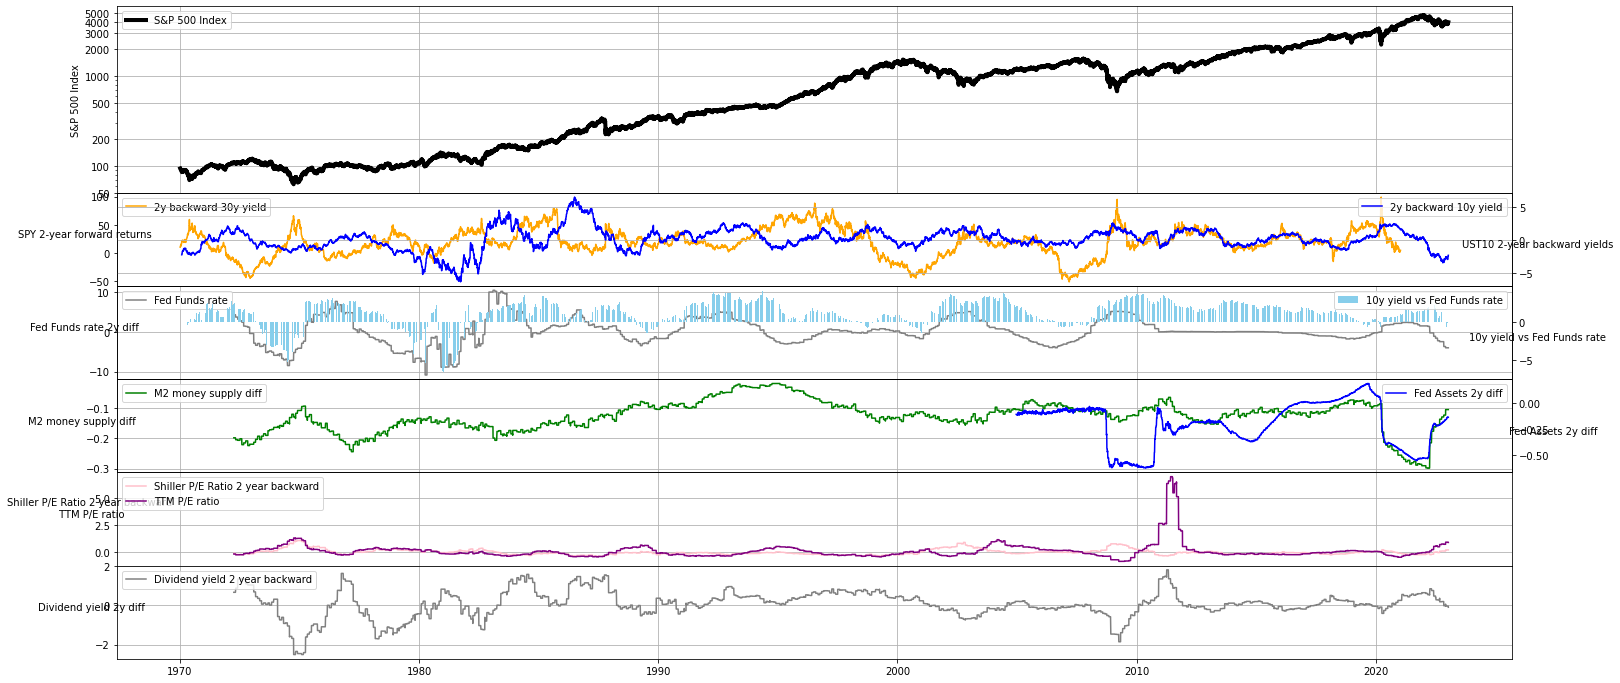

In [43]:
# plot just the 2-year forward and backward 

fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, 1, sharex=True, gridspec_kw={'height_ratios': [2,1,1,1,1,1]}, figsize=(25,12))

#plot spy data

ticks = [50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000]

ax0.plot(df['date'],df['close'], color = 'black', linewidth = 4)
ax0.set_ylabel('S&P 500 Index')
ax0.set_yscale('log')
ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index'])

# plot spy forward returns and 10y 2y backward return

ax1.plot(df['date'],df['spy_diff'], color = 'orange')
# axes object for secondary y-Axis
ax15 = ax1.twinx()
ax15.plot(df['date'],df['10y_yield_diff'], color = 'blue')
# giving labels to the axises
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY 2-year forward returns', rotation=0)
# secondary y-axis label
ax15.set_ylabel('UST10 2-year backward yields', rotation=0)

ax15.grid(True)

ax1.legend(labels=['2y backward 30y yield'], loc='upper left')
ax15.legend(labels=['2y backward 10y yield'])

#plot fed funds rate and 10y vs fed funds rate

ax2.plot(df['date'], df['fedfunds_2y_back_diff'], color = 'grey')
ax2.set_ylabel('Fed Funds rate 2y diff', rotation=0)
ax2.grid(True)
ax2.legend(labels=['Fed Funds rate'],loc='upper left')
ax25 = ax2.twinx()
ax25.bar(df['date'], df['fedfunds_10y_yield_diff'], color='skyblue')
ax25.set_ylabel('10y yield vs Fed Funds rate', rotation=0)
ax25.legend(labels=['10y yield vs Fed Funds rate'],loc='upper right')

# plot fed assets and M2 money supply
ax3.plot(df['date'], df['M2_2y_back_diff'], color='green')
ax3.set_ylabel('M2 money supply diff', rotation=0)
ax3.legend(labels=['M2 money supply diff'], loc='upper left', prop={'size': 10})
ax3.grid(True)
ax35 = ax3.twinx()
ax35.plot(df['date'],df['fed_assets_2y_back_diff'], color = 'blue')
ax35.set_ylabel('Fed Assets 2y diff', rotation=0)
ax35.legend(labels=['Fed Assets 2y diff'])


# plot Shiller P/E Ratio and P/E ratio

ax4.plot(df['date'], df['shiller_pe_2y_back_diff'], color='pink')
ax4.plot(df['date'], df['ttm_pe_ratio_2y_back_diff'], color='purple')
ax4.set_ylabel('Shiller P/E Ratio 2 year backward\n TTM P/E ratio', rotation=0)
ax4.legend(labels=['Shiller P/E Ratio 2 year backward', 'TTM P/E ratio'], loc='upper left', prop={'size': 10})
ax4.grid(True)

# plot dividend yield 
ax5.plot(df['date'], df['dividend_yield_2y_back_diff'], color='grey')
ax5.set_ylabel('Dividend yield 2y diff', rotation=0)
ax5.legend(labels=['Dividend yield 2 year backward'], loc='upper left', prop={'size': 10})
ax5.grid(True)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)

plt.show()



# Run prediction 

In [44]:
# Filter data between two dates
df_2008 = df.loc[(df['date'] >= '2008-01-01')
                     & (df['date'] <= str(yesterday))]

# select relevant columns 

df_2008 = df_2008[['date',
 '10y_yield_diff',
 'fedfunds_10y_yield_diff',
 'fedfunds_2y_back_diff',
 'M2_2y_back_diff',
 'fed_assets_2y_back_diff',
 'shiller_pe_2y_back_diff',
 'ttm_pe_ratio_2y_back_diff',
 'dividend_yield_2y_back_diff',
 'spy_diff']]                     

In [45]:
# reset index 

df_2008 = df_2008.reset_index(drop=True)

In [46]:
#df_2008.to_excel("check2.xlsx")

In [47]:
#select predictors 

predictors = df_2008.columns.to_list()

predictors = predictors[1:-1]

predictors

#select target

y = df_2008['spy_diff']


In [48]:
df_2008[['date', 'spy_diff']][:3277].tail(3)

,date,spy_diff
3274,2021-01-04,4.116036
3275,2021-01-05,2.179851
3276,2021-01-06,3.920350


In [49]:
#split data into test and train (days after the test start become "test" set)

# select first n rows using iloc

df_train = df_2008[:3277]

# fit polynomial regression of degree 1

x_columns = predictors

poly = PolynomialFeatures(degree = 1)
X_train = df_train[x_columns]
X_poly = poly.fit_transform(X_train)
y_train = df_train["spy_diff"][:3277]

poly.fit(X_poly, y_train)
lin2 = sklearn.linear_model.LinearRegression()
lin2.fit(X_poly, y_train)

LinearRegression()

In [50]:
# check the quality of the model

y_pred = lin2.predict(X_poly)

accuracy = r2_score(y_train, y_pred)*100

print(accuracy)

63.61037143027117


In [51]:
# check quality of predictions

X_total = df_2008[x_columns]

X_total_poly = poly.fit_transform(X_total)

y_total = df_2008['spy_diff']

y_total_pred = lin2.predict(X_total_poly)

In [52]:
# converting the NumPy array 
# to a Pandas series

y_total_pred = pd.Series(y_total_pred)

#create df for comparison

index_labels = df_2008['date'].tolist()

# Assign Index to Series

y_total.index = index_labels
y_total_pred.index = index_labels

# Concat Series by Changing Names
df_predictions=pd.concat({'spy_diff': y_total,
              'predicted_spy_diff': y_total_pred}, axis=1)

df_predictions.head(2)

,spy_diff,predicted_spy_diff
2008-01-02,-23.287201,27.467561
2008-01-03,-23.287201,27.467561


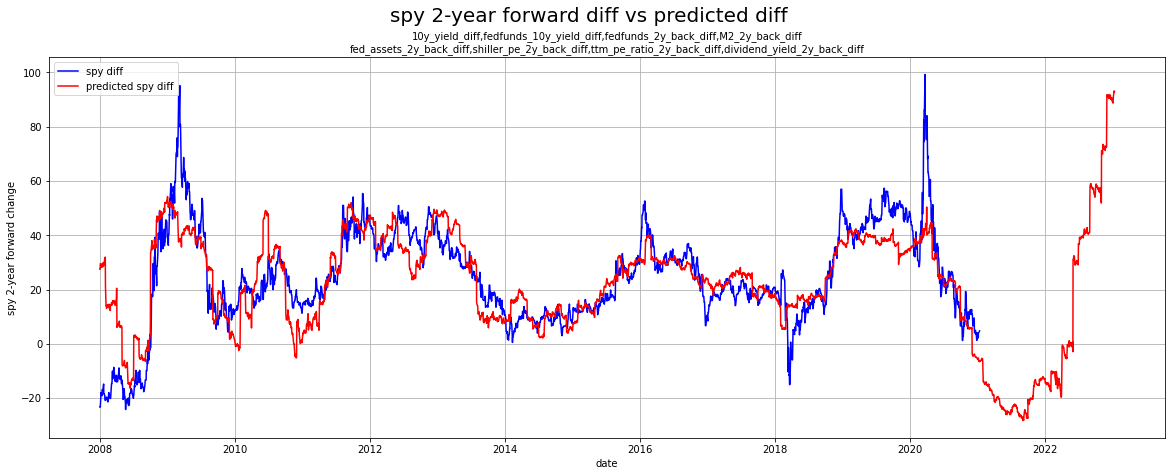

In [53]:
# plot predictions 

fig, ax = plt.subplots(figsize=(20,7))

fig.suptitle("spy 2-year forward diff vs predicted diff", fontsize=20)

x = df_predictions.index

labels = ['spy diff', 'predicted spy diff']

ax.plot(x, df_predictions['spy_diff'], color='blue')
ax.plot(x, df_predictions['predicted_spy_diff'], color='red')
#ax.axvline(dt.datetime(2022, 7, 20), color = 'pink', linestyle = '--', linewidth = 4)
ax.set_ylabel('spy 2-year forward change')
ax.set_xlabel('date')
ax.set_title( '10y_yield_diff,fedfunds_10y_yield_diff,fedfunds_2y_back_diff,M2_2y_back_diff\nfed_assets_2y_back_diff,shiller_pe_2y_back_diff,ttm_pe_ratio_2y_back_diff,dividend_yield_2y_back_diff', size=10)
ax.legend(labels, loc='best')
ax.grid(True)

# Run prediction adding the actual metrics as well as the 2-year change

In [109]:
# Filter data between two dates
df_2008 = df.loc[(df['date'] >= '2008-01-01')
                     & (df['date'] <= str(yesterday))]

# select relevant columns 

df_2008 = df_2008[['date',
 '10y_yield_diff',
 'fedfunds_10y_yield_diff',
 'fedfunds_2y_back_diff',
 'M2_2y_back_diff',
 'fed_assets_2y_back_diff',
 'shiller_pe_2y_back_diff',
 'ttm_pe_ratio_2y_back_diff',
 'dividend_yield_2y_back_diff',
 '10y_yield',
 'fed_funds_rate',
 'shiller_pe',
 'ttm_pe_ratio',
 'dividend_yield',
 'spy_diff']]

In [110]:
#fill empty values 

df_2008['10y_yield'].fillna(method='ffill', inplace=True)
df_2008['fed_funds_rate'].fillna(method='ffill', inplace=True)
df_2008['shiller_pe'].fillna(method='ffill', inplace=True)
df_2008['ttm_pe_ratio'].fillna(method='ffill', inplace=True)
df_2008['dividend_yield'].fillna(method='ffill', inplace=True)

In [111]:
#select predictors 

predictors = df_2008.columns.to_list()

predictors = predictors[1:-1]

predictors

#select target

y = df_2008['spy_diff'][:3277]


In [112]:
#split data into test and train (days after the test start become "test" set)

# select first n rows using iloc

df_train = df_2008[:3277]

# fit polynomial regression of degree 1

x_columns = predictors

poly = PolynomialFeatures(degree = 1)
X_train = df_train[x_columns]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

X_poly = poly.fit_transform(X_train_std)

#define y-variable

y_train = df_train["spy_diff"][:3277]

#y_train = np.asarray(df_train["spy_diff"])
#y_train = y_train.reshape(-1,1)
#y_train_std = scaler.fit_transform(y_train)

poly.fit(X_poly, y_train)
lin2 = sklearn.linear_model.LinearRegression()
lin2.fit(X_poly, y_train)

LinearRegression()

In [113]:
# check the quality of the model

from sklearn.metrics import mean_squared_error

y_pred = lin2.predict(X_poly)

#calculate acuracy
accuracy = r2_score(y_train, y_pred)*100

print('MSE: %.2f' % mean_squared_error(y_train, y_pred))
print('R^2: %.2f' % r2_score(y_train, y_pred))


MSE: 69.41
R^2: 0.78


In [114]:
# check quality of predictions

X_total = df_2008[x_columns]

X_total = scaler.fit_transform(X_total)
X_total_poly = poly.fit_transform(X_total)

y_total = df_2008['spy_diff']

y_total_pred = lin2.predict(X_total_poly)

In [115]:
# converting the NumPy array 
# to a Pandas series

y_total_pred = pd.Series(y_total_pred)

#create df for comparison

index_labels = df_2008['date'].tolist()

# Assign Index to Series

y_total.index = index_labels
y_total_pred.index = index_labels

# Concat Series by Changing Names
df_predictions=pd.concat({'spy_diff': y_total,
              'predicted_spy_diff': y_total_pred}, axis=1)

df_predictions.head(2)

,spy_diff,predicted_spy_diff
2008-01-02,-23.287201,-0.222725
2008-01-03,-23.287201,-0.222725


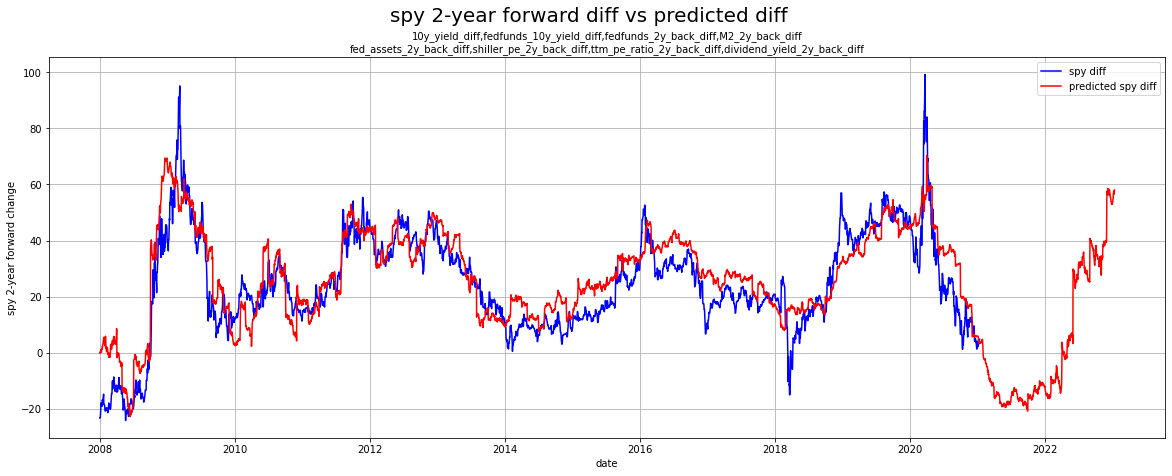

In [116]:
# plot predictions 

fig, ax = plt.subplots(figsize=(20,7))

fig.suptitle("spy 2-year forward diff vs predicted diff", fontsize=20)

x = df_predictions.index

labels = ['spy diff', 'predicted spy diff']

ax.plot(x, df_predictions['spy_diff'], color='blue')
ax.plot(x, df_predictions['predicted_spy_diff'], color='red')
#ax.axvline(dt.datetime(2022, 7, 20), color = 'pink', linestyle = '--', linewidth = 4)
ax.set_ylabel('spy 2-year forward change')
ax.set_xlabel('date')
ax.set_title( '10y_yield_diff,fedfunds_10y_yield_diff,fedfunds_2y_back_diff,M2_2y_back_diff\nfed_assets_2y_back_diff,shiller_pe_2y_back_diff,ttm_pe_ratio_2y_back_diff,dividend_yield_2y_back_diff', size=10)
ax.legend(labels, loc='best')
ax.grid(True)

In [117]:
# run the forecast on actual SPY levels

# Filter data between two dates
df_forecast = df.loc[(df['date'] >= '2008-01-01')
                     & (df['date'] <= str(yesterday))]

df_forecast = df_forecast.reset_index(drop=True)

df_forecast.tail(2)

,date,close,2years_forward,2year_forward_return,10y_yield,2year_back_10y_yield,spy_diff,10y_yield_diff,fed_funds_rate,fedfunds_10y_yield_diff,...,fed_assets_2y_back_diff,shiller_pe,2y_back_shiller_pe,shiller_pe_2y_back_diff,ttm_pe_ratio,2y_back_ttm_pe_ratio,ttm_pe_ratio_2y_back_diff,dividend_yield,2y_back_dividend_yield,dividend_yield_2y_back_diff
3783,2023-01-11,3969.610107,2025-01-10,NaN,3.554,NaN,NaN,-2.412,4.1,-0.546,...,-0.137835,27.95,NaN,0.208229,20.35,NaN,0.929238,1.69,NaN,-0.04
3784,2023-01-12,3983.169922,2025-01-11,NaN,3.449,1.132,NaN,-2.317,4.1,-0.651,...,-0.137835,27.95,33.77,0.208229,20.63,39.26,0.903054,1.75,1.65,-0.10


In [118]:
# merge predictions with forecast df

df_predictions = df_predictions.reset_index()

df_predictions = df_predictions.rename(columns={'index':'date'})

df_predictions = df_predictions[['date', 'predicted_spy_diff']]

df_forecast = pd.merge(df_forecast,
                       df_predictions,
                       on = 'date',
                       how = 'left')

df_forecast.tail(2)                       

,date,close,2years_forward,2year_forward_return,10y_yield,2year_back_10y_yield,spy_diff,10y_yield_diff,fed_funds_rate,fedfunds_10y_yield_diff,...,shiller_pe,2y_back_shiller_pe,shiller_pe_2y_back_diff,ttm_pe_ratio,2y_back_ttm_pe_ratio,ttm_pe_ratio_2y_back_diff,dividend_yield,2y_back_dividend_yield,dividend_yield_2y_back_diff,predicted_spy_diff
3783,2023-01-11,3969.610107,2025-01-10,NaN,3.554,NaN,NaN,-2.412,4.1,-0.546,...,27.95,NaN,0.208229,20.35,NaN,0.929238,1.69,NaN,-0.04,57.276599
3784,2023-01-12,3983.169922,2025-01-11,NaN,3.449,1.132,NaN,-2.317,4.1,-0.651,...,27.95,33.77,0.208229,20.63,39.26,0.903054,1.75,1.65,-0.10,57.992933


In [119]:
# add the forecast only from the moment there's no actual data available 

last_record = df_forecast.shape[0]-1

last_date = df_forecast['date'][last_record]

print(last_date)

2023-01-12 00:00:00


In [120]:
# run calculation for future SPY price 

spy_price_prediction = []

for i, j, k in zip(df_forecast['2years_forward'], df_forecast['close'],df_forecast['predicted_spy_diff']):
    if i > last_date:
        spy_price_prediction.append(j*(1+(k/100)))
    else:
        spy_price_prediction.append(np.nan)



In [121]:
# add predictions to the forecast df

df_forecast['spy_price_prediction'] = spy_price_prediction

In [122]:
# create a separate dataset with just price prediction and future dates 

df_future = df_forecast[['2years_forward', 'spy_price_prediction']].loc[df_forecast['2years_forward']> last_date]

df_future = df_future.rename(columns={'2years_forward':'date'})

df_future.reset_index(drop=True)

# create a separate dataset with just current price 

df_current = df_forecast[['date', 'close']]

df_current = df_current.reset_index(drop=True)

# concatenate 

df_current = pd.concat([df_current, df_future], sort=False)


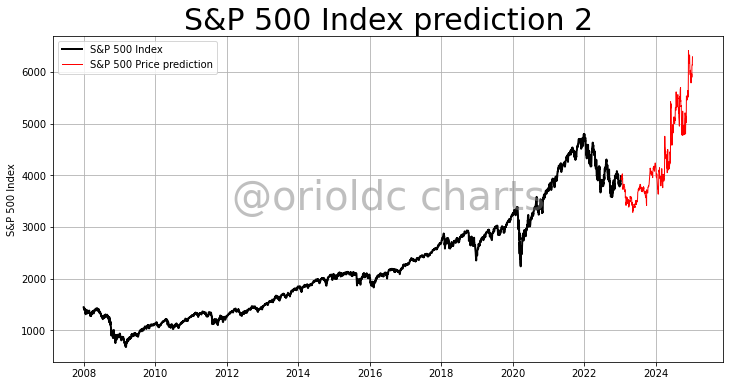

In [123]:
# chart data 

fig, (ax0) = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax0.plot(df_current['date'],df_current['close'], color = 'black', linewidth = 2)
ax0.plot(df_current['date'],df_current['spy_price_prediction'], color = 'red', linewidth = 1)
ax0.set_ylabel('S&P 500 Index')
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index', 'S&P 500 Price prediction'])
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')

plt.title("S&P 500 Index prediction 2", size=30)
plt.savefig("sp500_prediction_LR_SS_zoomout_{}.jpg".format(yesterday), facecolor='white', dpi=96)
plt.show()




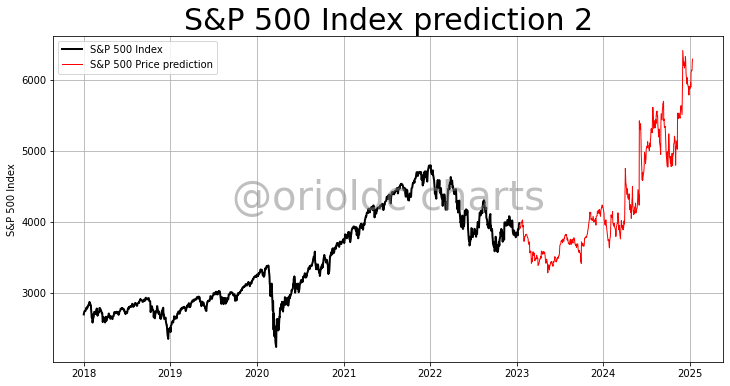

In [124]:
# Filter data between two dates
df_current2018 = df_current.loc[(df_current['date'] >= '2018-01-01')]
# chart data 

x = df_current2018['date']

y1 = df_current2018['close']

y2 = df_current2018['spy_price_prediction']

fig, (ax0) = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax0.plot(x,y1, color = 'black', linewidth = 2)
ax0.plot(x,y2, color = 'red', linewidth = 1)
ax0.set_ylabel('S&P 500 Index')
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index', 'S&P 500 Price prediction'])
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')


plt.title("S&P 500 Index prediction 2", size=30)
plt.savefig("sp500_prediction_SS_norm_{}.jpg".format(yesterday), facecolor='white', dpi=96)

plt.show()




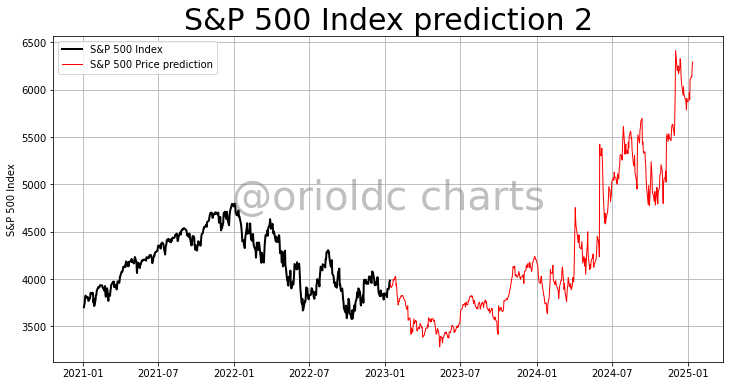

In [125]:
# Filter data between two dates
df_current2021 = df_current.loc[(df_current['date'] >= '2021-01-01')]
# chart data 

x = df_current2021['date']

y1 = df_current2021['close']

y2 = df_current2021['spy_price_prediction']

fig, (ax0) = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax0.plot(x,y1, color = 'black', linewidth = 2)
ax0.plot(x,y2, color = 'red', linewidth = 1)
ax0.set_ylabel('S&P 500 Index')
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index', 'S&P 500 Price prediction'])
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')


plt.title("S&P 500 Index prediction 2", size=30)
plt.savefig("sp500_prediction_SS_norm_zoom_{}.jpg".format(yesterday), facecolor='white', dpi=96)

plt.show()




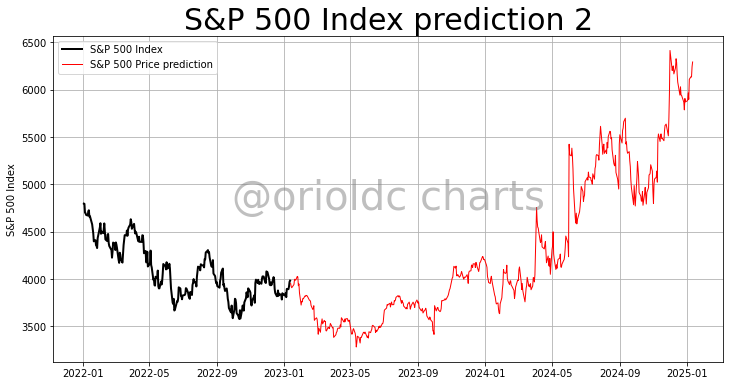

In [126]:
# Filter data between two dates
df_current2022 = df_current.loc[(df_current['date'] >= '2022-01-01')]
# chart data 

x = df_current2022['date']

y1 = df_current2022['close']

y2 = df_current2022['spy_price_prediction']

fig, (ax0) = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax0.plot(x,y1, color = 'black', linewidth = 2)
ax0.plot(x,y2, color = 'red', linewidth = 1)
ax0.set_ylabel('S&P 500 Index')
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index', 'S&P 500 Price prediction'])
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')


plt.title("S&P 500 Index prediction 2", size=30)
plt.savefig("sp500_prediction_SS_norm_zoom2_{}.jpg".format(yesterday), facecolor='white', dpi=96)

plt.show()




# Run prediction with different normalisation

In [62]:
# Filter data between two dates
df_2008 = df.loc[(df['date'] >= '2008-01-01')
                     & (df['date'] <= str(yesterday))]

# select relevant columns 

df_2008 = df_2008[['date',
 '10y_yield_diff',
 'fedfunds_10y_yield_diff',
 'fedfunds_2y_back_diff',
 'M2_2y_back_diff',
 'fed_assets_2y_back_diff',
 'shiller_pe_2y_back_diff',
 'ttm_pe_ratio_2y_back_diff',
 'dividend_yield_2y_back_diff',
 '10y_yield',
 'fed_funds_rate',
 'shiller_pe',
 'ttm_pe_ratio',
 'dividend_yield',
 'spy_diff']]

In [63]:
#fill empty values 

df_2008['10y_yield'].fillna(method='ffill', inplace=True)
df_2008['fed_funds_rate'].fillna(method='ffill', inplace=True)
df_2008['shiller_pe'].fillna(method='ffill', inplace=True)
df_2008['ttm_pe_ratio'].fillna(method='ffill', inplace=True)
df_2008['dividend_yield'].fillna(method='ffill', inplace=True)

In [64]:
#fill fed assets na with 0

# Replace on single column
df_2008["fed_assets_2y_back_diff"] = df_2008["fed_assets_2y_back_diff"].fillna(0)


In [65]:
#select predictors 

predictors = df_2008.columns.to_list()

predictors = predictors[1:-1]

predictors

#select target

y = df_2008['spy_diff']


In [66]:
#split data into test and train (days after the test start become "test" set)

# select first n rows using iloc

df_train = df_2008[:3277]

# fit polynomial regression of degree 1

x_columns = predictors

poly = PolynomialFeatures(degree = 1)
X_train = df_train[x_columns]

from sklearn.preprocessing import Normalizer

scaler = Normalizer()
X_train_std = scaler.fit_transform(X_train)

X_poly = poly.fit_transform(X_train_std)
#define y-variable

y_train = df_train['spy_diff'][:3277]
#y_train = np.asarray(df_train["spy_diff"])
#y_train = y_train.reshape(-1,1)
#y_train_std = scaler.fit_transform(y_train)

poly.fit(X_poly, y_train)
lin2 = sklearn.linear_model.LinearRegression()
lin2.fit(X_poly, y_train)

LinearRegression()

In [67]:
# check the quality of the model

from sklearn.metrics import mean_squared_error

y_pred = lin2.predict(X_poly)

#calculate acuracy
accuracy = r2_score(y_train, y_pred)*100

print('MSE: %.2f' % mean_squared_error(y_train, y_pred))
print('R^2: %.2f' % r2_score(y_train, y_pred))


MSE: 67.35
R^2: 0.79


In [68]:
# check quality of predictions

X_total = df_2008[x_columns]

X_total = scaler.fit_transform(X_total)
X_total_poly = poly.fit_transform(X_total)

y_total = df_2008['spy_diff']

y_total_pred = lin2.predict(X_total_poly)

In [69]:
# converting the NumPy array 
# to a Pandas series

y_total_pred = pd.Series(y_total_pred)

#create df for comparison

index_labels = df_2008['date'].tolist()

# Assign Index to Series

y_total.index = index_labels
y_total_pred.index = index_labels

# Concat Series by Changing Names
df_predictions=pd.concat({'spy_diff': y_total,
              'predicted_spy_diff': y_total_pred}, axis=1)

df_predictions.head(2)

,spy_diff,predicted_spy_diff
2008-01-02,-23.287201,-19.173911
2008-01-03,-23.287201,-19.173911


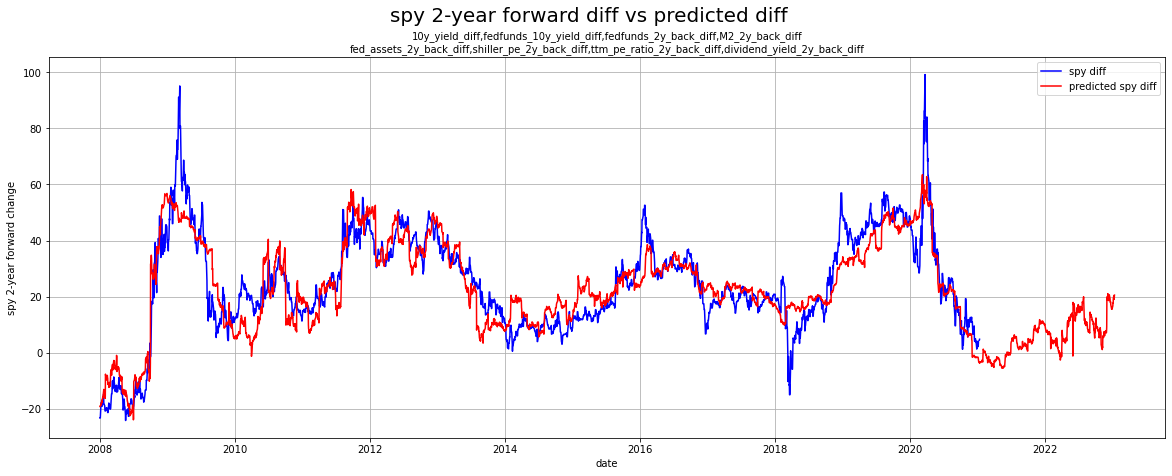

In [70]:
# plot predictions 

fig, ax = plt.subplots(figsize=(20,7))

fig.suptitle("spy 2-year forward diff vs predicted diff", fontsize=20)

x = df_predictions.index

labels = ['spy diff', 'predicted spy diff']

ax.plot(x, df_predictions['spy_diff'], color='blue')
ax.plot(x, df_predictions['predicted_spy_diff'], color='red')
#ax.axvline(dt.datetime(2022, 7, 20), color = 'pink', linestyle = '--', linewidth = 4)
ax.set_ylabel('spy 2-year forward change')
ax.set_xlabel('date')
ax.set_title( '10y_yield_diff,fedfunds_10y_yield_diff,fedfunds_2y_back_diff,M2_2y_back_diff\nfed_assets_2y_back_diff,shiller_pe_2y_back_diff,ttm_pe_ratio_2y_back_diff,dividend_yield_2y_back_diff', size=10)
ax.legend(labels, loc='best')
ax.grid(True)

In [71]:
# run the forecast on actual SPY levels

# Filter data between two dates
df_forecast = df.loc[(df['date'] >= '2008-01-01')
                     & (df['date'] <= str(yesterday))]

df_forecast = df_forecast.reset_index(drop=True)

df_forecast.tail(2)

,date,close,2years_forward,2year_forward_return,10y_yield,2year_back_10y_yield,spy_diff,10y_yield_diff,fed_funds_rate,fedfunds_10y_yield_diff,...,fed_assets_2y_back_diff,shiller_pe,2y_back_shiller_pe,shiller_pe_2y_back_diff,ttm_pe_ratio,2y_back_ttm_pe_ratio,ttm_pe_ratio_2y_back_diff,dividend_yield,2y_back_dividend_yield,dividend_yield_2y_back_diff
3783,2023-01-11,3969.610107,2025-01-10,NaN,3.554,NaN,NaN,-2.412,4.1,-0.546,...,-0.137835,27.95,NaN,0.208229,20.35,NaN,0.929238,1.69,NaN,-0.04
3784,2023-01-12,3983.169922,2025-01-11,NaN,3.449,1.132,NaN,-2.317,4.1,-0.651,...,-0.137835,27.95,33.77,0.208229,20.63,39.26,0.903054,1.75,1.65,-0.10


In [72]:
# merge predictions with forecast df

df_predictions = df_predictions.reset_index()

df_predictions = df_predictions.rename(columns={'index':'date'})

df_predictions = df_predictions[['date', 'predicted_spy_diff']]

df_forecast = pd.merge(df_forecast,
                       df_predictions,
                       on = 'date',
                       how = 'left')

df_forecast.tail(2)                       

,date,close,2years_forward,2year_forward_return,10y_yield,2year_back_10y_yield,spy_diff,10y_yield_diff,fed_funds_rate,fedfunds_10y_yield_diff,...,shiller_pe,2y_back_shiller_pe,shiller_pe_2y_back_diff,ttm_pe_ratio,2y_back_ttm_pe_ratio,ttm_pe_ratio_2y_back_diff,dividend_yield,2y_back_dividend_yield,dividend_yield_2y_back_diff,predicted_spy_diff
3783,2023-01-11,3969.610107,2025-01-10,NaN,3.554,NaN,NaN,-2.412,4.1,-0.546,...,27.95,NaN,0.208229,20.35,NaN,0.929238,1.69,NaN,-0.04,19.811095
3784,2023-01-12,3983.169922,2025-01-11,NaN,3.449,1.132,NaN,-2.317,4.1,-0.651,...,27.95,33.77,0.208229,20.63,39.26,0.903054,1.75,1.65,-0.10,20.537202


In [73]:
# add the forecast only from the moment there's no actual data available 

last_record = df_forecast.shape[0]-1

last_date = df_forecast['date'][last_record]

print(last_date)

2023-01-12 00:00:00


In [74]:
# run calculation for future SPY price 

spy_price_prediction = []

for i, j, k in zip(df_forecast['2years_forward'], df_forecast['close'],df_forecast['predicted_spy_diff']):
    if i > last_date:
        spy_price_prediction.append(j*(1+(k/100)))
    else:
        spy_price_prediction.append(np.nan)



In [75]:
# add predictions to the forecast df

df_forecast['spy_price_prediction'] = spy_price_prediction

In [76]:
# create a separate dataset with just price prediction and future dates 

df_future = df_forecast[['2years_forward', 'spy_price_prediction']].loc[df_forecast['2years_forward']> last_date]

df_future = df_future.rename(columns={'2years_forward':'date'})

df_future.reset_index(drop=True)

# create a separate dataset with just current price 

df_current = df_forecast[['date', 'close']]

df_current = df_current.reset_index(drop=True)

# concatenate 

df_current = pd.concat([df_current, df_future], sort=False)


In [77]:
df_current.tail(2)

,date,close,spy_price_prediction
3783,2025-01-10,NaN,4756.033333
3784,2025-01-11,NaN,4801.201557


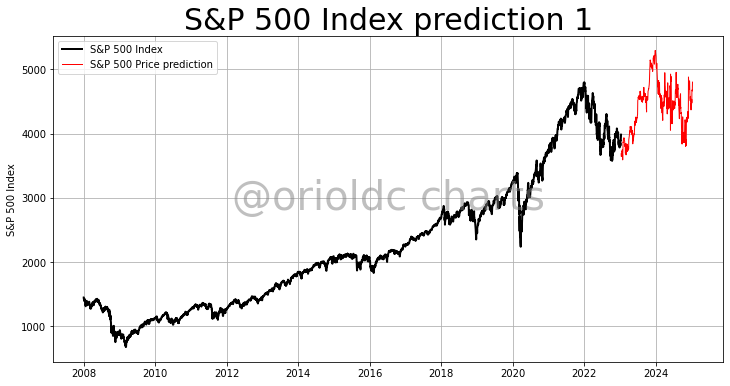

In [78]:
# chart data 

fig, (ax0) = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax0.plot(df_current['date'],df_current['close'], color = 'black', linewidth = 2)
ax0.plot(df_current['date'],df_current['spy_price_prediction'], color = 'red', linewidth = 1)
ax0.set_ylabel('S&P 500 Index')
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index', 'S&P 500 Price prediction'])
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')

plt.title("S&P 500 Index prediction 1", size=30)
plt.savefig("sp500_prediction_LR_norm_zoomout_{}.jpg".format(yesterday), facecolor='white', dpi=96)
plt.show()




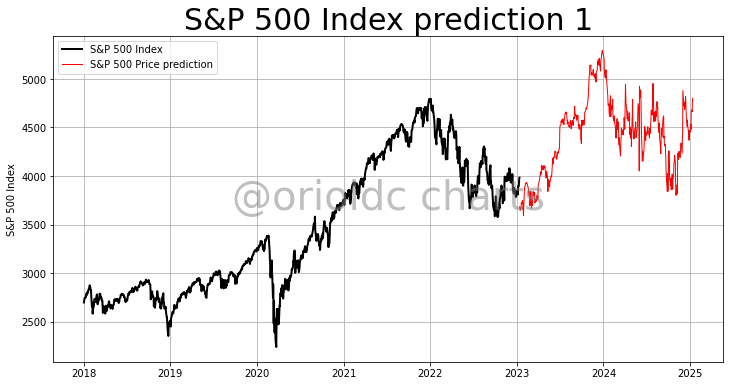

In [79]:
# Filter data between two dates
df_current2018 = df_current.loc[(df_current['date'] >= '2018-01-01')]
# chart data 

x = df_current2018['date']

y1 = df_current2018['close']

y2 = df_current2018['spy_price_prediction']

fig, (ax0) = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax0.plot(x,y1, color = 'black', linewidth = 2)
ax0.plot(x,y2, color = 'red', linewidth = 1)
ax0.set_ylabel('S&P 500 Index')
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index', 'S&P 500 Price prediction'])
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')


plt.title("S&P 500 Index prediction 1", size=30)
plt.savefig("sp500_prediction_LR_norm_{}.jpg".format(yesterday), facecolor='white', dpi=96)

plt.show()




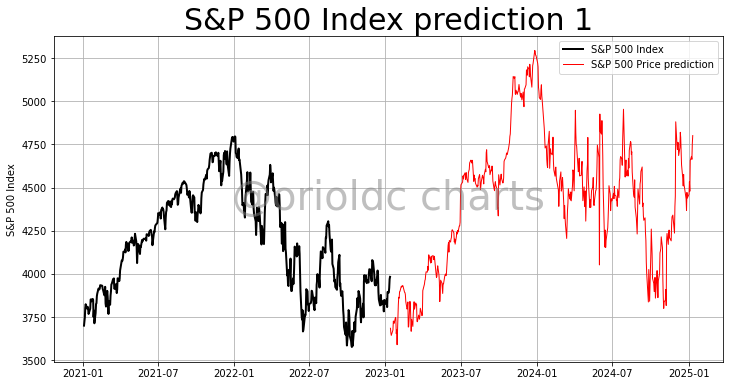

In [80]:
# Filter data between two dates
df_current2021 = df_current.loc[(df_current['date'] >= '2021-01-01')]
# chart data 

x = df_current2021['date']

y1 = df_current2021['close']

y2 = df_current2021['spy_price_prediction']

fig, (ax0) = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax0.plot(x,y1, color = 'black', linewidth = 2)
ax0.plot(x,y2, color = 'red', linewidth = 1)
ax0.set_ylabel('S&P 500 Index')
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index', 'S&P 500 Price prediction'])
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')


plt.title("S&P 500 Index prediction 1", size=30)
plt.savefig("sp500_prediction_LR_norm_zoom_{}.jpg".format(yesterday), facecolor='white', dpi=96)

plt.show()




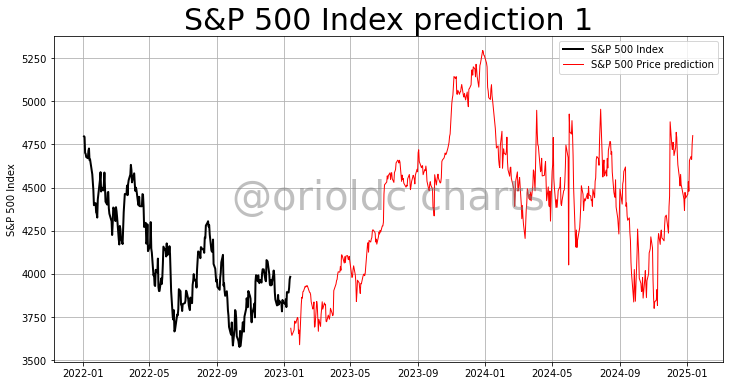

In [81]:
# Filter data between two dates
df_current2022 = df_current.loc[(df_current['date'] >= '2022-01-01')]
# chart data 

x = df_current2022['date']

y1 = df_current2022['close']

y2 = df_current2022['spy_price_prediction']

fig, (ax0) = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax0.plot(x,y1, color = 'black', linewidth = 2)
ax0.plot(x,y2, color = 'red', linewidth = 1)
ax0.set_ylabel('S&P 500 Index')
ax0.grid(True)
ax0.legend(labels=['S&P 500 Index', 'S&P 500 Price prediction'])
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center')


plt.title("S&P 500 Index prediction 1", size=30)
plt.savefig("sp500_prediction_LR_norm_zoom2_{}.jpg".format(yesterday), facecolor='white', dpi=96)

plt.show()




# Run prediction using less training data


In [82]:
# Filter data between two dates
df_2008 = df.loc[(df['date'] >= '2002-01-01')
                     & (df['date'] <= str(yesterday))]

# select relevant columns 

df_2008 = df_2008[['date',
 '10y_yield_diff',
 'fedfunds_10y_yield_diff',
 'fedfunds_2y_back_diff',
 'M2_2y_back_diff',
 'fed_assets_2y_back_diff',
 'shiller_pe_2y_back_diff',
 'ttm_pe_ratio_2y_back_diff',
 'dividend_yield_2y_back_diff',
 '10y_yield',
 'fed_funds_rate',
 'shiller_pe',
 'ttm_pe_ratio',
 'dividend_yield',
 'spy_diff']]

In [83]:
#fill empty values 

df_2008['10y_yield'].fillna(method='ffill', inplace=True)
df_2008['fed_funds_rate'].fillna(method='ffill', inplace=True)
df_2008['shiller_pe'].fillna(method='ffill', inplace=True)
df_2008['ttm_pe_ratio'].fillna(method='ffill', inplace=True)
df_2008['dividend_yield'].fillna(method='ffill', inplace=True)

In [84]:
#fill fed assets na with 0

# Replace on single column
df_2008["fed_assets_2y_back_diff"] = df_2008["fed_assets_2y_back_diff"].fillna(0)


In [85]:
df_2008 = df_2008.reset_index(drop=True)

In [86]:
#select predictors 

predictors = df_2008.columns.to_list()

predictors = predictors[1:-1]

predictors

#select target

y = df_2008['spy_diff']


In [87]:
#define index value to understand where spy 2-year forward data ends

i = df_2008.loc[df_2008['date']=='2021-01-06']

i = i.index[0]

train_size = int(df_2008.shape[0]*0.85)

test_size = train_size+1
test_size2 = i
print(train_size)
print(test_size)

4500
4501


In [88]:
#split data into test and train (days after the test start become "test" set)

# select first n rows using iloc

df_train = df_2008[:train_size]
df_test = df_2008[test_size:test_size2]

# fit polynomial regression of degree 1

x_columns = predictors

poly = PolynomialFeatures(degree = 1)
X_train = df_train[x_columns]
X_test = df_test[x_columns]

from sklearn.preprocessing import Normalizer

scaler = Normalizer()
X_train_std = scaler.fit_transform(X_train)
X_poly = poly.fit_transform(X_train_std)

X_test_std = scaler.fit_transform(X_test)
X_test_poly = poly.fit_transform(X_test_std)


#define y-variable

y_train = df_train['spy_diff']
y_test = df_test['spy_diff']
#y_train = np.asarray(df_train["spy_diff"])
#y_train = y_train.reshape(-1,1)
#y_train_std = scaler.fit_transform(y_train)

poly.fit(X_poly, y_train)
lin2 = sklearn.linear_model.LinearRegression()
lin2.fit(X_poly, y_train)

LinearRegression()

In [89]:
# check the quality of the model

from sklearn.metrics import mean_squared_error

y_pred = lin2.predict(X_test_poly)

#calculate acuracy
accuracy = r2_score(y_test, y_pred)*100

print('MSE: %.2f' % mean_squared_error(y_test, y_pred))
print('R^2: %.2f' % r2_score(y_test, y_pred))


MSE: 648.07
R^2: -0.60


In [90]:
# converting the NumPy array 
# to a Pandas series

y_pred = pd.Series(y_pred)

#create df for comparison

index_labels = df_test['date'].tolist()

# Assign Index to Series

y_test.index = index_labels
y_pred.index = index_labels

# Concat Series by Changing Names
df_predictions=pd.concat({'spy_diff': y_test,
              'predicted_spy_diff': y_pred}, axis=1)

df_predictions.head(2)

,spy_diff,predicted_spy_diff
2019-11-18,50.180167,35.907706
2019-11-19,50.777844,35.888056


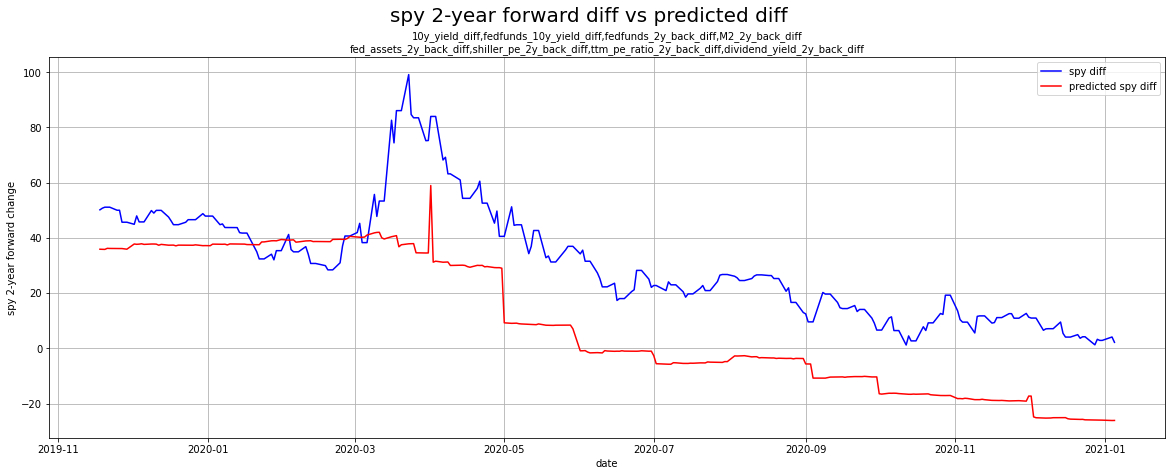

In [91]:
# plot predictions 

fig, ax = plt.subplots(figsize=(20,7))

fig.suptitle("spy 2-year forward diff vs predicted diff", fontsize=20)

x = df_predictions.index

labels = ['spy diff', 'predicted spy diff']

ax.plot(x, df_predictions['spy_diff'], color='blue')
ax.plot(x, df_predictions['predicted_spy_diff'], color='red')
#ax.axvline(dt.datetime(2022, 7, 20), color = 'pink', linestyle = '--', linewidth = 4)
ax.set_ylabel('spy 2-year forward change')
ax.set_xlabel('date')
ax.set_title( '10y_yield_diff,fedfunds_10y_yield_diff,fedfunds_2y_back_diff,M2_2y_back_diff\nfed_assets_2y_back_diff,shiller_pe_2y_back_diff,ttm_pe_ratio_2y_back_diff,dividend_yield_2y_back_diff', size=10)
ax.legend(labels, loc='best')
ax.grid(True)

In [92]:
# check quality of predictions

X_total = df_2008[x_columns]

X_total = scaler.fit_transform(X_total)
X_total_poly = poly.fit_transform(X_total)

y_total = df_2008['spy_diff']

y_total_pred = lin2.predict(X_total_poly)

In [93]:
# converting the NumPy array 
# to a Pandas series

y_total_pred = pd.Series(y_total_pred)

#create df for comparison

index_labels = df_2008['date'].tolist()

# Assign Index to Series

y_total.index = index_labels
y_total_pred.index = index_labels

# Concat Series by Changing Names
df_predictions=pd.concat({'spy_diff': y_total,
              'predicted_spy_diff': y_total_pred}, axis=1)

df_predictions.head(2)

,spy_diff,predicted_spy_diff
2002-01-02,-4.000282,10.595094
2002-01-03,-4.000282,10.628419


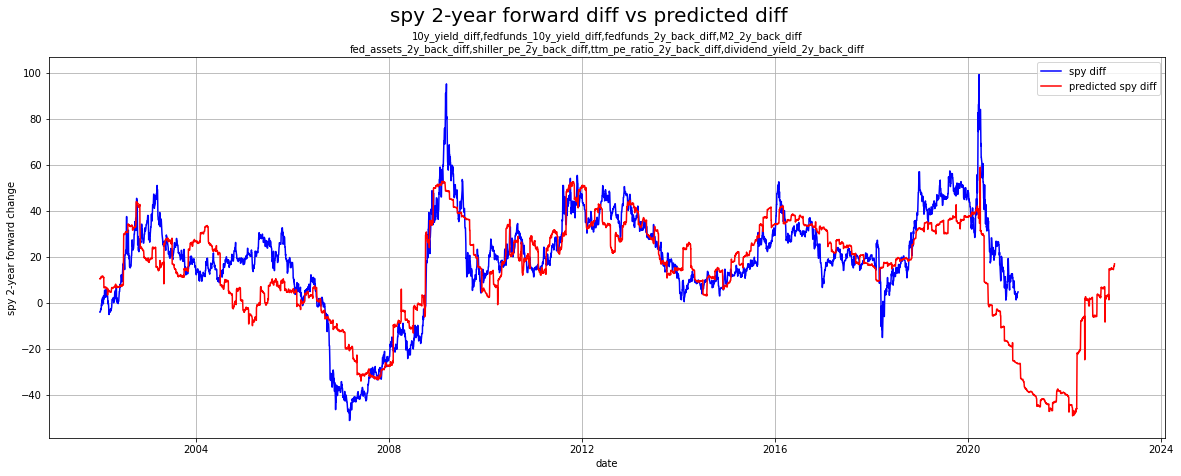

In [94]:
# plot predictions 

fig, ax = plt.subplots(figsize=(20,7))

fig.suptitle("spy 2-year forward diff vs predicted diff", fontsize=20)

x = df_predictions.index

labels = ['spy diff', 'predicted spy diff']

ax.plot(x, df_predictions['spy_diff'], color='blue')
ax.plot(x, df_predictions['predicted_spy_diff'], color='red')
#ax.axvline(dt.datetime(2022, 7, 20), color = 'pink', linestyle = '--', linewidth = 4)
ax.set_ylabel('spy 2-year forward change')
ax.set_xlabel('date')
ax.set_title( '10y_yield_diff,fedfunds_10y_yield_diff,fedfunds_2y_back_diff,M2_2y_back_diff\nfed_assets_2y_back_diff,shiller_pe_2y_back_diff,ttm_pe_ratio_2y_back_diff,dividend_yield_2y_back_diff', size=10)
ax.legend(labels, loc='best')
ax.grid(True)

Future work:

- Run feature selection using OLS 
- Chart the expected 2year change in SPY into the actual price chart

# run feature selection before running regression

In [95]:
# Filter data between two dates
df_2008 = df.loc[(df['date'] >= '2008-01-01')
                     & (df['date'] <= str(yesterday))]

# select relevant columns 

df_2008 = df_2008[['date',
 '10y_yield_diff',
 'fedfunds_10y_yield_diff',
 'fedfunds_2y_back_diff',
 'M2_2y_back_diff',
 'fed_assets_2y_back_diff',
 'shiller_pe_2y_back_diff',
 'ttm_pe_ratio_2y_back_diff',
 'dividend_yield_2y_back_diff',
 '10y_yield',
 'fed_funds_rate',
 'shiller_pe',
 'ttm_pe_ratio',
 'dividend_yield',
 'spy_diff']]

In [96]:
#fill empty values 

df_2008['10y_yield'].fillna(method='ffill', inplace=True)
df_2008['fed_funds_rate'].fillna(method='ffill', inplace=True)
df_2008['shiller_pe'].fillna(method='ffill', inplace=True)
df_2008['ttm_pe_ratio'].fillna(method='ffill', inplace=True)
df_2008['dividend_yield'].fillna(method='ffill', inplace=True)

In [97]:
#select predictors 

predictors = df_2008.columns.to_list()

x_columns = predictors[1:-1]

#select target

y = df_2008['spy_diff'][:3277]


In [98]:

## creating function to get model statistics

import statsmodels.api as sm
def get_stats():
    x = df_2008[x_columns][:3277]
    #scaler = Normalizer()
    #x = scaler.fit_transform(x)
    results = sm.OLS(y, x).fit()
    print(results.summary())
    
get_stats()

                                 OLS Regression Results                                
Dep. Variable:               spy_diff   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              3205.
Date:                Fri, 13 Jan 2023   Prob (F-statistic):                        0.00
Time:                        13:35:42   Log-Likelihood:                         -11669.
No. Observations:                3277   AIC:                                  2.336e+04
Df Residuals:                    3265   BIC:                                  2.343e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [99]:
#start removing fields that have a high p-value (depending on the level of significance chosen)

x_columns.remove("fedfunds_10y_yield_diff")
get_stats()

                                 OLS Regression Results                                
Dep. Variable:               spy_diff   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              3205.
Date:                Fri, 13 Jan 2023   Prob (F-statistic):                        0.00
Time:                        13:35:42   Log-Likelihood:                         -11669.
No. Observations:                3277   AIC:                                  2.336e+04
Df Residuals:                    3265   BIC:                                  2.343e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [100]:
#continue removing fields that have a high p-value

x_columns.remove("ttm_pe_ratio_2y_back_diff")
get_stats()

                                 OLS Regression Results                                
Dep. Variable:               spy_diff   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              3496.
Date:                Fri, 13 Jan 2023   Prob (F-statistic):                        0.00
Time:                        13:35:42   Log-Likelihood:                         -11669.
No. Observations:                3277   AIC:                                  2.336e+04
Df Residuals:                    3266   BIC:                                  2.343e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [101]:
#see final columns selected 

x_columns

['10y_yield_diff',
 'fedfunds_2y_back_diff',
 'M2_2y_back_diff',
 'fed_assets_2y_back_diff',
 'shiller_pe_2y_back_diff',
 'dividend_yield_2y_back_diff',
 '10y_yield',
 'fed_funds_rate',
 'shiller_pe',
 'ttm_pe_ratio',
 'dividend_yield']

In [102]:
#define index value to understand where spy 2-year forward data ends

i = df_2008.loc[df_2008['date']=='2021-01-06']

i = i.index[0]

train_size = int(df_2008.shape[0]*0.85)

test_size = train_size+1
test_size2 = i
print(train_size)
print(test_size)

3217
3218


In [103]:
#split data into test and train (days after the test start become "test" set)

# select first n rows using iloc

X_train = df_2008[x_columns][:train_size]

poly = PolynomialFeatures(degree = 1)
scaler = Normalizer()
X_train_std = scaler.fit_transform(X_train)
X_poly = poly.fit_transform(X_train_std)
#define y-variable
y_train = df_train['spy_diff'][:train_size]
#y_train = np.asarray(df_train["spy_diff"])
#y_train = y_train.reshape(-1,1)
#y_train_std = scaler.fit_transform(y_train)

poly.fit(X_poly, y_train)
lin2 = sklearn.linear_model.LinearRegression()
lin2.fit(X_poly, y_train)

LinearRegression()

In [104]:
# check the quality of the model

from sklearn.metrics import mean_squared_error

y_pred = lin2.predict(X_poly)

#calculate acuracy
accuracy = r2_score(y_train, y_pred)*100

print('MSE: %.2f' % mean_squared_error(y_train, y_pred))
print('R^2: %.2f' % r2_score(y_train, y_pred))


MSE: 279.93
R^2: 0.49


In [105]:
# check quality of predictions

X_total = df_2008[x_columns]

X_total = scaler.fit_transform(X_total)
X_total_poly = poly.fit_transform(X_total)

y_total = df_2008['spy_diff']

y_total_pred = lin2.predict(X_total_poly)

In [106]:
# converting the NumPy array 
# to a Pandas series

y_total_pred = pd.Series(y_total_pred)

#create df for comparison

index_labels = df_2008['date'].tolist()

# Assign Index to Series

y_total.index = index_labels
y_total_pred.index = index_labels

# Concat Series by Changing Names
df_predictions=pd.concat({'spy_diff': y_total,
              'predicted_spy_diff': y_total_pred}, axis=1)

df_predictions.head(2)

,spy_diff,predicted_spy_diff
2008-01-02,-23.287201,17.399111
2008-01-03,-23.287201,17.399111


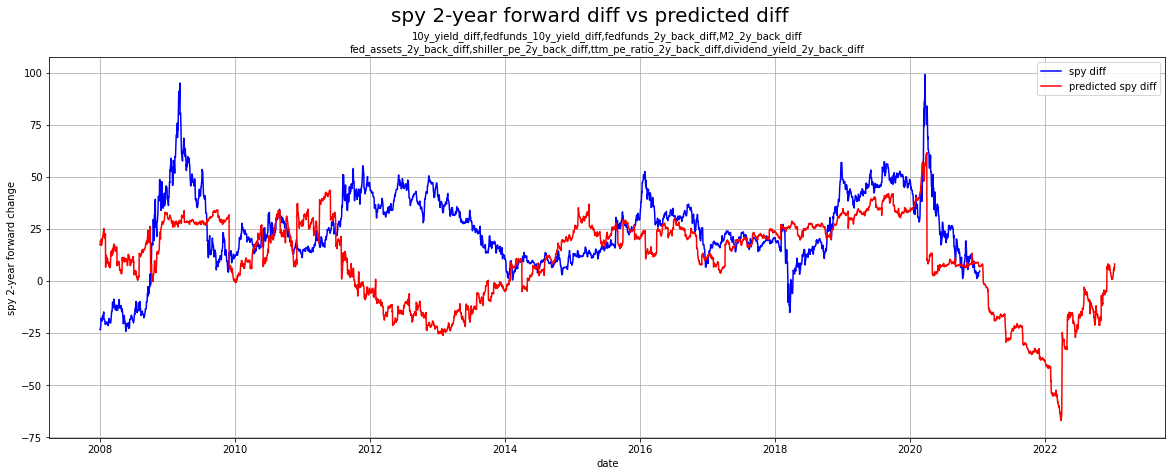

In [107]:
# plot predictions 

fig, ax = plt.subplots(figsize=(20,7))

fig.suptitle("spy 2-year forward diff vs predicted diff", fontsize=20)

x = df_predictions.index

labels = ['spy diff', 'predicted spy diff']

ax.plot(x, df_predictions['spy_diff'], color='blue')
ax.plot(x, df_predictions['predicted_spy_diff'], color='red')
#ax.axvline(dt.datetime(2022, 7, 20), color = 'pink', linestyle = '--', linewidth = 4)
ax.set_ylabel('spy 2-year forward change')
ax.set_xlabel('date')
ax.set_title( '10y_yield_diff,fedfunds_10y_yield_diff,fedfunds_2y_back_diff,M2_2y_back_diff\nfed_assets_2y_back_diff,shiller_pe_2y_back_diff,ttm_pe_ratio_2y_back_diff,dividend_yield_2y_back_diff', size=10)
ax.legend(labels, loc='best')
ax.grid(True)

In [108]:
x_columns

['10y_yield_diff',
 'fedfunds_2y_back_diff',
 'M2_2y_back_diff',
 'fed_assets_2y_back_diff',
 'shiller_pe_2y_back_diff',
 'dividend_yield_2y_back_diff',
 '10y_yield',
 'fed_funds_rate',
 'shiller_pe',
 'ttm_pe_ratio',
 'dividend_yield']